In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [56]:
path_EMA_MOSAIC = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Clinical projects/TILES/Data_googledrive/EMA surveys -MOSAIC.csv'
path_demog_prepost = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Clinical projects/TILES/Data_googledrive/Demog, PRE, PST survey composites.csv'

In [57]:
#read in data_demog_prepost, contains demographic information and pre/post questionaires
data_demog_prepost = pd.read_csv(path_demog_prepost)
data_demog_prepost = pd.DataFrame(data = data_demog_prepost)
print('Original Demog shape:\n', data_demog_prepost.shape, '\n')
#replace blnaks with nans
data_demog_prepost = data_demog_prepost.replace(' ', np.nan)
#ensure no replicate ID (eg one row per participant in study)
print('Original Demog unique IDs:\n', data_demog_prepost['ID'].unique().shape, '\n')
print('Original Demog missing value couts:\n', data_demog_prepost.isnull().sum(), '\n')
print('Original Demog data types:\n', data_demog_prepost.info(), '\n')

Original Demog shape:
 (212, 179) 

Original Demog unique IDs:
 (212,) 

Original Demog missing value couts:
 ID                                                                0
date_time                                                         0
shipley.vocab                                                     0
shipley.abs                                                       0
irb                                                               0
itp                                                               0
ocb                                                               0
inter.deviance                                                    0
org.deviance                                                      0
extraversion                                                      0
agreeableness                                                     0
conscientiousness                                                 0
neuroticism                                                       0
openne

In [58]:
#split off demographic data
data_demog = data_demog_prepost[['ID', 'date_time', 'GenInst',
       'gender', 'age', 'bornUS', 'country', 'lang', 'englyrs', 'educ',
       'jobstat', 'occup', 'occup_TEXT', 'supervise', 'quantsup', 'size',
       'duration', 'income', 'record_id', 'redcap_event_name',
       'demographics_timestamp', 'race', 'ethnic', 'relationship',
       'pregnant', 'children', 'housing', 'household___1',
       'household___2', 'household___3', 'household___4', 'household___5',
       'household___6', 'household___7', 'currentposition',
       'position_other', 'certifications', 'nurseyears', 'shift', 'hours',
       'overtime', 'commute_type', 'commute_time', 'extrajob',
       'extrahours', 'student', 'demographics_complete']]
data_demog.head()

,ID,date_time,GenInst,gender,age,bornUS,country,lang,englyrs,educ,jobstat,occup,occup_TEXT,supervise,quantsup,size,duration,income,record_id,redcap_event_name,demographics_timestamp,race,ethnic,relationship,pregnant,children,housing,household___1,household___2,household___3,household___4,household___5,household___6,household___7,currentposition,position_other,certifications,nurseyears,shift,hours,overtime,commute_type,commute_time,extrajob,extrahours,student,demographics_complete
0,SD1001,2/20/2018,1,1,53,2,Guatemala,2,52,4,2,11,NaN,2,NaN,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,NaN,7,30,1,36,0,2,3,0,0,9,2
1,SD1002,2/22/2018,1,2,56,2,Viet Nam,2,38,4,2,10,NaN,1,2,4,10,7,11,prestudy_survey_arm_1,2018-02-27 11:33:22,3,0,3,0,0,1,0,0,0,1,0,0,0,1,NaN,6,12,1,36,24,2,3,0,0,9,2
2,SD1003,2/23/2018,1,2,25,1,NaN,1,NaN,4,2,10,NaN,2,NaN,4,2,4,9,prestudy_survey_arm_1,2018-02-26 21:23:59,3,0,1,0,0,2,0,0,0,0,1,0,0,1,NaN,7,1,1,36,12,2,1,0,0,9,2
3,SD1004,2/23/2018,1,2,26,1,NaN,1,NaN,3,2,10,NaN,2,NaN,4,7,2,19,prestudy_survey_arm_1,2018-03-01 12:54:07,6,1,1,0,0,2,1,0,0,0,0,0,0,2,NaN,7,5,1,36,0,6,1,0,0,9,2
4,SD1005,2/23/2018,1,2,31,2,mexico,2,25,5,2,10,NaN,2,NaN,4,10,4,8,prestudy_survey_arm_1,2018-02-24 21:27:46,1,1,2,0,2,2,1,0,1,1,0,0,0,2,NaN,7,10,1,36,0,2,2,0,0,9,2


In [59]:
print(data_demog.isna().sum())
print(data_demog.shape)
data_demog = data_demog.dropna(thresh = 100, axis = 1)
print(data_demog.shape)
data_demog['uid'] = data_demog['ID']
data_demog.head()

ID                          0
date_time                   0
GenInst                     0
gender                      0
age                         0
bornUS                      0
country                   119
lang                        0
englyrs                   127
educ                        0
jobstat                     0
occup                       0
occup_TEXT                192
supervise                   1
quantsup                  157
size                        0
duration                    1
income                      0
record_id                   4
redcap_event_name           4
demographics_timestamp      4
race                       45
ethnic                      5
relationship               21
pregnant                    6
children                    7
housing                     4
household___1               4
household___2               4
household___3               4
household___4               4
household___5               4
household___6               4
household_

,ID,date_time,GenInst,gender,age,bornUS,lang,educ,jobstat,occup,supervise,size,duration,income,record_id,redcap_event_name,demographics_timestamp,race,ethnic,relationship,pregnant,children,housing,household___1,household___2,household___3,household___4,household___5,household___6,household___7,currentposition,certifications,nurseyears,shift,hours,overtime,commute_type,commute_time,extrajob,extrahours,student,demographics_complete,uid
0,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2,SD1001
1,SD1002,2/22/2018,1,2,56,2,2,4,2,10,1,4,10,7,11,prestudy_survey_arm_1,2018-02-27 11:33:22,3,0,3,0,0,1,0,0,0,1,0,0,0,1,6,12,1,36,24,2,3,0,0,9,2,SD1002
2,SD1003,2/23/2018,1,2,25,1,1,4,2,10,2,4,2,4,9,prestudy_survey_arm_1,2018-02-26 21:23:59,3,0,1,0,0,2,0,0,0,0,1,0,0,1,7,1,1,36,12,2,1,0,0,9,2,SD1003
3,SD1004,2/23/2018,1,2,26,1,1,3,2,10,2,4,7,2,19,prestudy_survey_arm_1,2018-03-01 12:54:07,6,1,1,0,0,2,1,0,0,0,0,0,0,2,7,5,1,36,0,6,1,0,0,9,2,SD1004
4,SD1005,2/23/2018,1,2,31,2,2,5,2,10,2,4,10,4,8,prestudy_survey_arm_1,2018-02-24 21:27:46,1,1,2,0,2,2,1,0,1,1,0,0,0,2,7,10,1,36,0,2,2,0,0,9,2,SD1005


In [60]:
data = pd.read_csv(path_EMA_MOSAIC)
data = pd.DataFrame(data = data)
print('Original MOSAIC EMA shape:\n', data.shape, '\n')
print('Original MOSAIC EMA survey type counts:\n', data['survey_type'].value_counts(), '\n')
print('Original MOSAIC EMA missing value couts:\n', data.isnull().sum(), '\n')
print('Original MOSAIC EMA data types:\n', data.info(), '\n')

Original MOSAIC EMA shape:
 (11398, 25) 

Original MOSAIC EMA survey type counts:
 health         5619
job            4964
personality     815
Name: survey_type, dtype: int64 

Original MOSAIC EMA missing value couts:
 uid                    0
survey_type            0
timestamp              0
itp_mgt             9027
irb_mgt             9024
ocb_mgt             9037
cwb_mgt             9039
neu_mgt            10593
con_mgt            10596
ext_mgt            10593
agr_mgt            10593
ope_mgt            10593
pos_af_mgt           120
neg_af_mgt           121
anxiety_mgt          111
stress_mgt            86
alcohol_mgt         5845
tobacco_mgt         5847
exercise_mgt        5861
sleep_mgt           5842
interaction_mgt        0
activity_mgt          30
location_mgt          53
event_mgt             68
work_mgt            6497
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11398 entries, 0 to 11397
Data columns (total 25 columns):
uid                11398 non-nul

In [4]:
#data consists of three different EMA surveys (health, job, personality), each with different set of questions asked
data.groupby('survey_type').count()

,uid,timestamp,itp_mgt,irb_mgt,ocb_mgt,cwb_mgt,neu_mgt,con_mgt,ext_mgt,agr_mgt,ope_mgt,pos_af_mgt,neg_af_mgt,anxiety_mgt,stress_mgt,alcohol_mgt,tobacco_mgt,exercise_mgt,sleep_mgt,interaction_mgt,activity_mgt,location_mgt,event_mgt,work_mgt
survey_type,,,,,,,,,,,,,,,,,,,,,,,,
health,5619,5619,0,0,0,0,0,0,0,0,0,5569,5568,5576,5587,5553,5551,5537,5556,5619,5604,5596,5592,0
job,4964,4964,2371,2374,2361,2359,0,0,0,0,0,4903,4903,4905,4919,0,0,0,0,4964,4950,4936,4927,4901
personality,815,815,0,0,0,0,805,802,805,805,805,806,806,806,806,0,0,0,0,815,814,813,811,0


In [15]:
data.groupby(['survey_type', 'stress_mgt'])['uid'].count()

survey_type  stress_mgt
health       1.0           2874
             2.0           1405
             3.0           1065
             4.0            186
             5.0             57
job          1.0           2392
             2.0           1191
             3.0           1064
             4.0            211
             5.0             61
personality  1.0            392
             2.0            221
             3.0            147
             4.0             34
             5.0             12
Name: uid, dtype: int64

In [5]:
#interested in stress as starting variable
data.groupby(['survey_type', 'stress_mgt']).mean()

itp_mgt    irb_mgt   ocb_mgt   cwb_mgt   neu_mgt   con_mgt   ext_mgt   agr_mgt   ope_mgt  pos_af_mgt  neg_af_mgt  anxiety_mgt  alcohol_mgt  tobacco_mgt  exercise_mgt  sleep_mgt  interaction_mgt  activity_mgt  location_mgt  event_mgt  work_mgt
survey_type stress_mgt                                                                                                                                                                                                                                                     
health      1.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   12.977344    5.517782     1.108711     0.325087     0.237404    269.787592   6.010794         2.067502      5.732777      1.910546   0.040376       NaN
            2.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   12.848962    6.263422     1.583155     0.292980     0.117014    250.433718   6.015409         1.916726      5.174377      2.177936   0.091103       NaN
            3.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   12.264151    7.937736     2.230914     0.192891     0.160833    257.022814   5.804429         1.860094      4.914554      2.235681   0.127700       NaN
            4.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   12.124324   11.383784     3.086022     0.266304     0.521505    145.010753   5.359730         1.919355      4.935484      2.204301   0.236559       NaN
            5.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   11.175439   14.315789     3.684211     0.149123     2.571429    117.263158   5.546491         1.807018      4.929825      1.912281   0.385965       NaN
job         1.0         4.530664  43.864130  7.580328  0.914661       NaN       NaN       NaN       NaN       NaN   12.861099    5.505245     1.093960          NaN          NaN           NaN        NaN         1.808528      4.959448      1.918444   0.053116  0.391779
            2.0         4.500000  44.315287  7.579200  1.004777       NaN       NaN       NaN       NaN       NaN   12.388186    6.216034     1.573232          NaN          NaN           NaN        NaN         1.730479      4.609572      1.988245   0.089840  0.535021
            3.0         4.445988  43.875576  7.577399  1.112150       NaN       NaN       NaN       NaN       NaN   12.320452    7.830349     2.159585          NaN          NaN           NaN        NaN         1.646617      4.052681      2.054614   0.173095  0.619093
            4.0         4.392435  42.900709  7.453901  1.312057       NaN       NaN       NaN       NaN       NaN   12.706161   10.781991     2.815166          NaN          NaN           NaN        NaN         1.649289      3.426540      2.018957   0.194313  0.672986
            5.0         4.363636  41.787879  7.181818  1.424242       NaN       NaN       NaN       NaN       NaN   11.983607   14.098361     3.475410          NaN          NaN           NaN        NaN         1.491803      4.295082      2.049180   0.393443  0.540984
personality 1.0              NaN        NaN       NaN       NaN  2.189744  4.136598  3.207692  3.973077  3.368895   12.774359    5.469231     1.092308          NaN          NaN           NaN        NaN         1.928571      5.237245      1.905612   0.038265       NaN
            2.0              NaN        NaN       NaN       NaN  2.506849  4.155963  3.077626  3.785388  3.247727   12.086364    6.463636     1.554545          NaN          NaN           NaN        NaN         1.796380      4.280543      1.986425   0.049774       NaN
            3.0              NaN        NaN       NaN       NaN  2.612245  4.034014  3.292517  3.755102  3.350340   12.197279    7.585034     2.163265          NaN          NaN           NaN        NaN         1.639456      4.496599      2.040816   0.142857       NaN
     

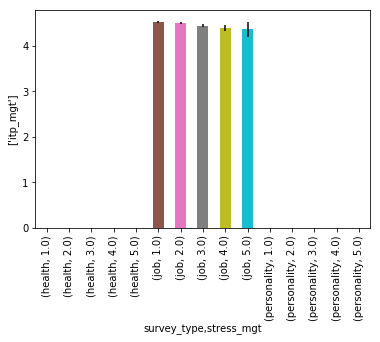

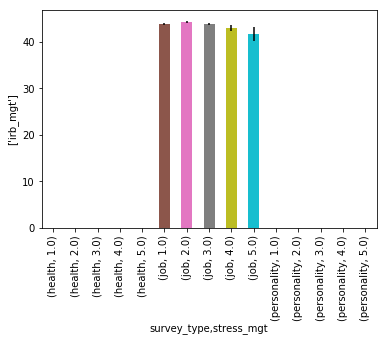

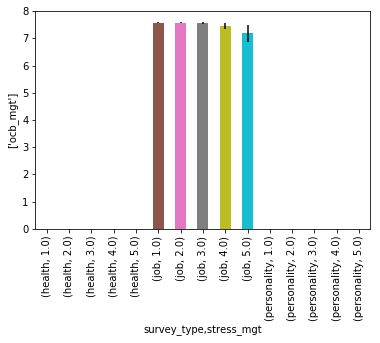

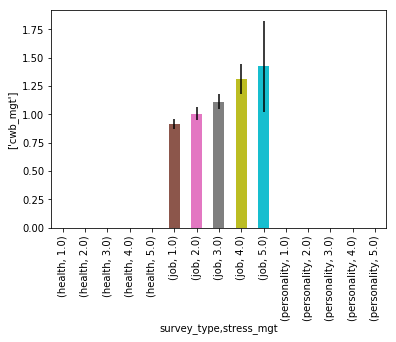

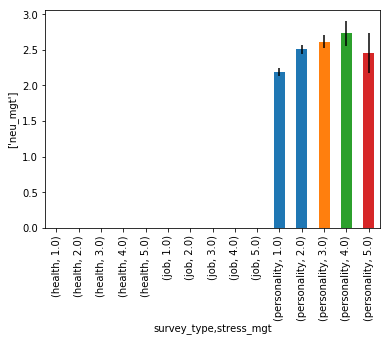

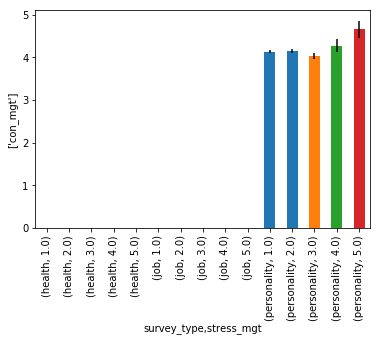

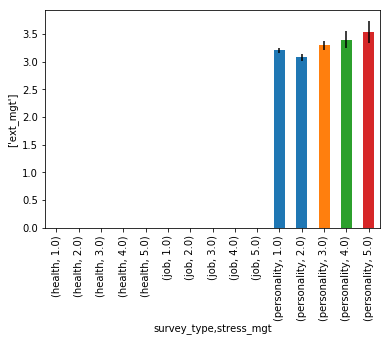

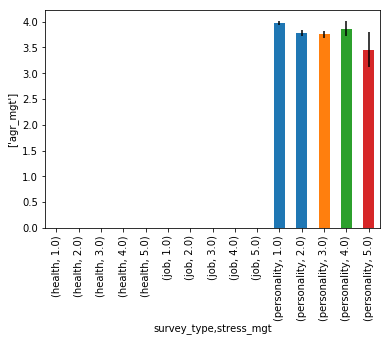

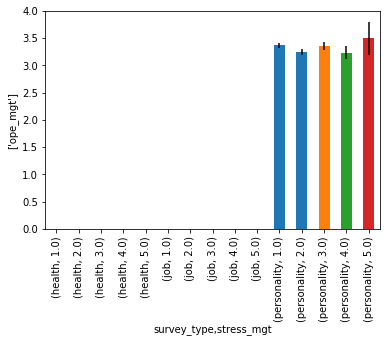

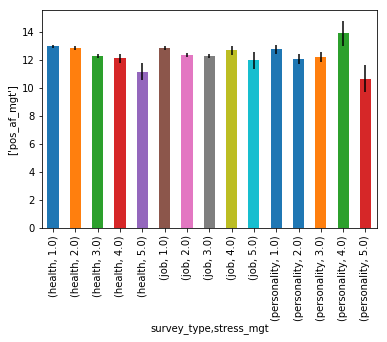

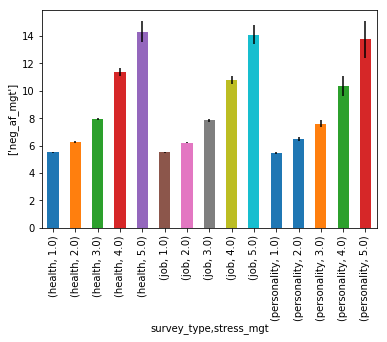

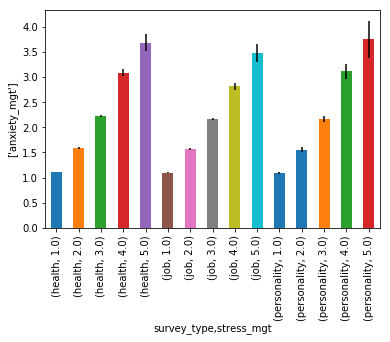

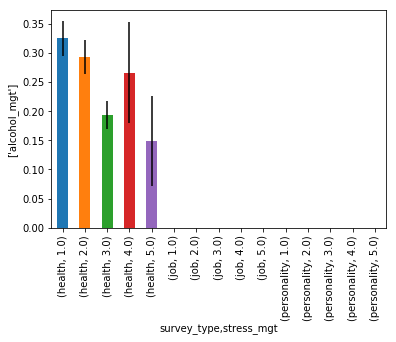

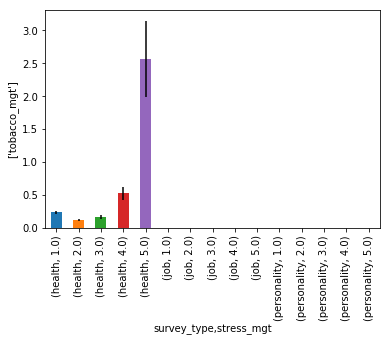

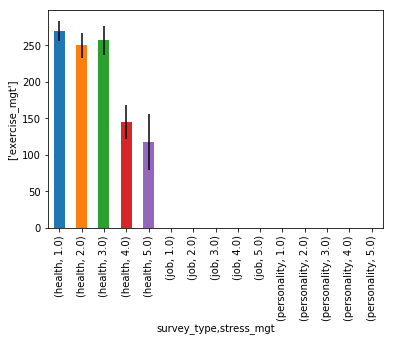

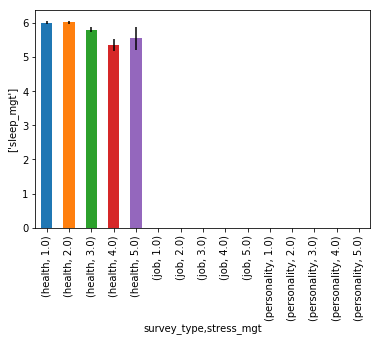

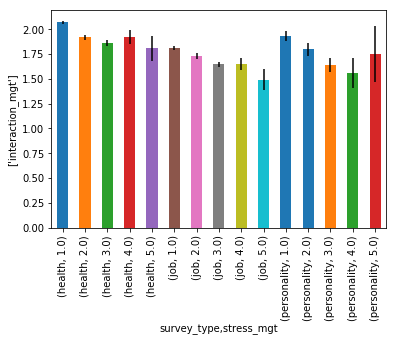

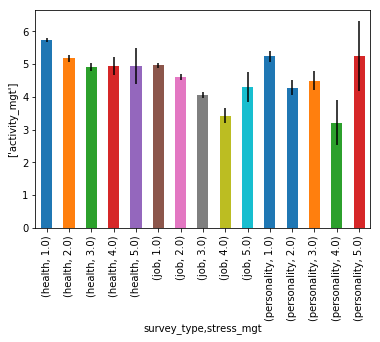

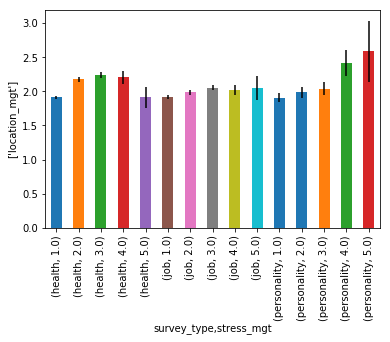

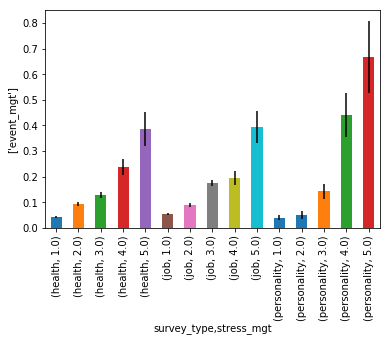

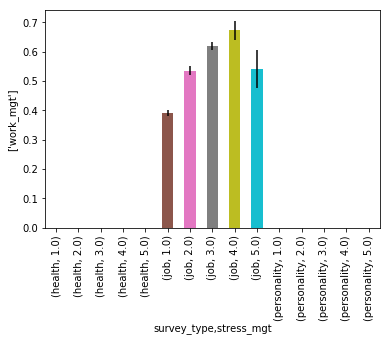

In [16]:
#lets look at how each parameter changes as a result of reported stress levels for each survey types (eg secondary question of whether survey type affects reponses)

#get column names (eg parameters)
parameters = data.groupby('stress_mgt').mean().columns.values

for param in parameters:
    data.groupby(['survey_type', 'stress_mgt'])[param].mean().plot(kind='bar', yerr=data.groupby(['survey_type', 'stress_mgt'])[param].sem())
    plt.ylabel([param])
    plt.show()

In [64]:
data.merge(data_demog, on = 'uid', how = 'inner')

,uid,survey_type,timestamp,itp_mgt,irb_mgt,ocb_mgt,cwb_mgt,neu_mgt,con_mgt,ext_mgt,agr_mgt,ope_mgt,pos_af_mgt,neg_af_mgt,anxiety_mgt,stress_mgt,alcohol_mgt,tobacco_mgt,exercise_mgt,sleep_mgt,interaction_mgt,activity_mgt,location_mgt,event_mgt,work_mgt,ID,date_time,GenInst,gender,age,bornUS,lang,educ,jobstat,occup,supervise,size,duration,income,record_id,redcap_event_name,demographics_timestamp,race,ethnic,relationship,pregnant,children,housing,household___1,household___2,household___3,household___4,household___5,household___6,household___7,currentposition,certifications,nurseyears,shift,hours,overtime,commute_type,commute_time,extrajob,extrahours,student,demographics_complete
0,SD1001,job,2018-03-05 18:00:29,4.666666,49.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,11.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,8.0,2.0,0.0,1.0,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
1,SD1001,health,2018-03-06 06:00:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,6.0,1.0,1.0,1.0,0.0,0.0,5.00,3.0,1.0,2.0,0.0,NaN,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
2,SD1001,job,2018-03-07 19:00:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,5.0,1.0,0.0,0.0,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
3,SD1001,personality,2018-03-08 14:23:35,NaN,NaN,NaN,NaN,1.5,5.0,2.5,2.5,3.0,17.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,11.0,1.0,0.0,NaN,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
4,SD1001,health,2018-03-09 07:27:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,8.0,2.0,3.0,0.0,0.0,0.0,6.00,3.0,3.0,4.0,0.0,NaN,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
5,SD1001,job,2018-03-10 18:04:54,5.000000,45.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,15.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,3.0,10.0,2.0,0.0,1.0,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
6,SD1001,health,2018-03-12 06:03:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,8.0,1.0,1.0,0.0,0.0,0.0,6.00,1.0,1.0,2.0,0.0,NaN,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
7,SD1002,job,2018-03-05 18:51:16,4.000000,49.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,17.0,5.0,2.0,3.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,0.0,1.0,SD1002,2/22/2018,1,2,56,2,2,4,2,10,1,4,10,7,11,prestudy_survey_arm_1,2018-02-27 11:33:22,3,0,3,0,0,1,0,0,0,1,0,0,0,1,6,12,1,36,24,2,3,0,0,9,2
8,SD1002,health,2018-03-06 07:26:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,5.0,2.0,2.0,0.0,0.0,0.0,5.00,1.0,1.0,2.0,0.0,NaN,SD1002,2/22/2018,1,2,56,2,2,4,2,10,1,4,10,7,11,prestudy_survey_arm_1,2018-02-27 11:33:22,3,0,3,0,0,1,0,0,0,1,0,0,0,1,6,12,1,36,24,2,3,0,0,9,2
9,SD1002,job,2018-03-07 20:06:35,4.333334,49.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,5.0,1.0,0.0,1.0,SD1002,2/22/2018,1,2,56,2,2,4,2,10,1,4,10,7,11,prestudy_survey_arm_1,2018-02-27 11:33:22,3,0,3,0,0,1,0,0,0,1,0,0,0,1,6,12,1,36,24,2,3,0,0,9,2


In [ ]:
#create separate data frame for each survey
print('Health EMA data', '\n')
print('Missing values per column', '\n', data[data['survey_type'] == 'health'].isnull().sum(), '\n')
data_health = data[data['survey_type'] == 'health'].dropna(thresh = 100, axis = 1)
print(data_health.shape, '\n', '\n')

print('Job EMA data', '\n')
print('Missing values per column', '\n', data[data['survey_type'] == 'job'].isnull().sum(), '\n')
data_job = data[data['survey_type'] == 'job'].dropna(thresh = 100, axis = 1)
print(data_job.shape, '\n', '\n')

print('Personality EMA data', '\n')
print('Missing values per column', '\n', data[data['survey_type'] == 'personality'].isnull().sum(), '\n')
data_personality = data[data['survey_type'] == 'personality'].dropna(thresh = 100, axis = 1)
print(data_personality.shape, '\n', '\n')